# Solving Overdetermined Systems

## Approach
- Normalize data
- Cluster to best cluster
- Find solution to each system of three equations from clusters, and average the solutions
- Find solution algebraically
- Compare solutions and see how they differ
- Use an approach where if the system is unsolvable, take the average plane

In [1]:
# Imports

import csv
from collections import Counter
from itertools import combinations
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import statistics

## Creating Data
* `readcsv`: Takes in a csv file and imports that data
    * Input: a filename (e.g. "testdata.csv")
    * Output: a matrix where each row represents an equation
* `makedataNum`: Takes in a number of clusters and generates a random number of equations, with the equations clustered in the specified number of groups. Equations are stored in a matrix.
    * Input: a natural number with the number of clusters
    * Output: a matrix where each row represents an equation
* `makedataRandom`: Takes in a number of equations, and generates that number of equations randomly. Equations are stored in a matrix.
    * Input: a natural number with the number of equations
    * Output: a matrix where each row represents an equation

In [2]:
# Get data from a csv file
def readcsv(filename):
    matrix = []
    
    with open(filename) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            matrix += [row]
    return np.array(matrix).astype(float)

In [3]:
# Get three dimensional planes
def makedataNum(numclusters, dim):
    matrix = []
    for i in range(numclusters):
        numpoints = random.randint(5,20)
        norm = []
        for k in range(dim):
            norm += [random.uniform(10, 40) * (math.pow(-1, random.randint(0,2)))]
        constant = random.uniform(0, 20) * (math.pow(-1, random.randint(0,2)))
        for j in range(numpoints):
            newnorm = list(map(lambda x: random.uniform(-2,2) + x, norm))
            c = random.random() + constant
            multiplier = random.uniform(0,10)
            row = list(map(lambda x: x * multiplier, newnorm + [c]))
            matrix += [row]
    return np.array(matrix)

In [4]:
def makedataNum2(numclusters, dim):
    matrix = []
    for i in range(numclusters):
        numpoints = random.randint(5,20)
        norm = []
        for k in range(dim):
            norm += [random.uniform(-10, 10)]
        constant = random.uniform(50, 100)
        for j in range(numpoints):
            newnorm = list(map(lambda x: random.uniform(-5,5) + x, norm))
            c = random.random() + constant
            multiplier = random.uniform(0,10)
            row = list(map(lambda x: x * multiplier, newnorm + [c]))
            matrix += [row]
    return np.array(matrix)

In [5]:
def makedataRandom(numequations, dim):
    matrix = []
    for j in range(numequations):
        norm = []
        for k in range(dim):
            norm += [random.uniform(10, 40) * (math.pow(-1, random.randint(0,2)))]
        c = random.uniform(0, 20) * (math.pow(-1, random.randint(0,2)))
        multiplier = random.uniform(0,10)
        row = list(map(lambda x: x * multiplier, norm + [c]))
        matrix += [row]
    return np.array(matrix)

In [6]:
def makedataRandom2(numequations, dim):
    matrix = []
    for j in range(numequations):
        norm = []
        for k in range(dim):
            norm += [random.uniform(10, 40)]
        c = random.uniform(50, 100)
        multiplier = random.uniform(0,10)
        row = list(map(lambda x: x * multiplier, norm + [c]))
        matrix += [row]
    return np.array(matrix)

## Normalizing Data
* `normalize`: Use the L2 norm to normalize the data to make every equation in a matrix have a unit normal
    * Input: matrix with rows as equations
    * Output: matrix with each row having equations with unit norms
* `normalizeL1`: Use the L1 norm to normalize the data to make every equation in a matrix have a unit normal
    * Input: matrix with rows as equations
    * Output: matrix with each row having equations with unit norms

In [7]:
"""Input: matrix with rows as equations"""
def normalize(matrix):
    normMatrix = []
    for i in range(len(matrix)):
        vector = np.array(matrix[i][:(len(matrix[i]) - 1)])
        norm = np.linalg.norm(vector)        
        normVector = matrix[i] / norm
        # Standardize that first term is nonnegative
        if normVector[0] < 0:
            normVector = normVector * -1
        normMatrix += [normVector]
    return np.array(normMatrix)

In [8]:
"""Input: matrix with rows as equations"""
def normalizeL1(matrix):
    normMatrix = []
    for i in range(len(matrix)):
        vector = np.array(matrix[i][:(len(matrix[i]) - 1)])
        norm = 0
        for a in vector:
            norm += np.abs(a)
        normVector = matrix[i] / norm
        # Standardize that first term is nonnegative
        if normVector[0] < 0:
            normVector = normVector * -1
        normMatrix += [normVector]
    return np.array(normMatrix)

## Clustering Data Points
* Overall approach: Use k-means clustering
* To find the actual optimal cluster of k, plot the sum squared errors with each k, and find an "elbow" in the graph. The location of that elbow indicates what k we should cluster with

### Functions
* `bestkcluster`: Plots a graph of the sum squared errors clustering with different values of k
    * Input: a matrix of equations `matrix`, the maximum number of clusters to test `maxclusters`
* `kcluster`: Cluster the equations of the system into a specified number of clusters
    * Input: matrix of equations `matrix`, the number of clusters `k`
    * Output: matrix of equations representing the center of the clusters

In [9]:
# Plot sum of squared errors for k means clustering
# for each k <= maxclusters
# Elbow of graph = optimal number of clusters
def bestkcluster(matrix, maxclusters):
    sse = [] # sum of squared distances for each k
    for k in range(1, maxclusters+1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(matrix[:, 0:len(matrix[0])])
        centers = kmeans.cluster_centers_
        sse += [sum(np.min(cdist(matrix, centers, 'euclidean'), axis=1)) / matrix.shape[0]]
    plt.plot(list(range(1,maxclusters+1)), sse)
    plt.show()

# Find the clusters for k means clustering for a
# given k. Use bestkcluster to find optimal k
def kcluster(matrix, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(matrix)
    return kmeans.cluster_centers_

# A version of kcluster where the norms are clustered, not the
# equations themselves. This yields better results
def kclusteraverage(matrix, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(matrix[:, 0:(len(matrix[0])-1)])
    
    ## Find closest center
    centers = kmeans.cluster_centers_
    indices = []
    c = []
    for row in matrix:
        e = []
        for i in range(k):
            e += [np.linalg.norm(row[0:(len(matrix[0])-1)] - centers[i])]
        c += [row[len(matrix[0])-1]]
        indices += [e.index(min(e))]
    
    cluster = []
    for j in range(k):
        constants = np.array(c)
        conditional = [i == j for i in indices]
        constants =  constants[conditional]
        cluster += [centers[j].tolist() + [statistics.mean(constants)]]
    print(cluster)
    return np.array(cluster)

## Finding Solutions

* `algsolution`: Algebraically finds the solution to the system of equations
    * Input: matrix with rows of the form ax + by + cz = d
    * Output: Solution as (x, y, z)
* `solution`: Solves the system of equations when the system is not overdetermined
    * Input: matrix with rows of the form ax + by + cz = d, and number of rows are one less then the number of columns
    * Output: Solution as (x, y, z)
* `avgsolution`: Take all subsets of an overdetermined system that together gives a solution, then averages among the solutions
    * Input: matrix with rows of the form ax + by + cz = d
    * Output: Solution as (x, y, z)

In [10]:
def algsolution(matrix):
    
    # Equation of the form Ax = b
    A = matrix[:, 0:(len(matrix[0])-1)]
    b = matrix[:, (len(matrix[0])-1)]
    
    # Estimate x = (A.T A)^-1 (A.T y) = B^-1 c
    # for B = (A.T A) and c = A.T y
    B = np.dot(np.transpose(A), A)
    c = np.dot(np.transpose(A), b)
    x = np.dot(np.linalg.inv(B), c)
    return x

In [11]:
def solution(matrix):
    if len(matrix) != len(matrix[0]) - 1:
        print("Overdetermined system")
        return
    coefficients = []
    consts = []
    for i in range(len(matrix)):
        coefficients += [matrix[i][:len(matrix[i])-1]]
        consts += [matrix[i][len(matrix[i])-1]]
    return np.linalg.solve(coefficients, consts)

In [12]:
def avgsolution(matrix):
    solutions = []
    totals = [0] * (len(matrix[0]) - 1)
    combos = combinations(matrix, len(matrix[0]) - 1)
    for c in combos:
        npc = np.array(c)
        coefficients = npc[:, 0:(len(matrix[0])  - 1)]
        consts = np.reshape(npc[:, (len(matrix[0]) - 1)], ((len(matrix[0]) - 1),1))
        sol = np.linalg.solve(coefficients, consts)
        solutions += [sol]
        for i in range(len(matrix[0]) - 1):
            totals[i] += sol[i]
    numsolutions = len(solutions)
    print(np.array(solutions))
    solution = np.array(totals) / numsolutions
    return list(map(lambda x: x[0], solution))

## Inconsistent System Handling
* When there are two parallel planes, only use their average z-intercept

In [13]:
def averageinconsistency(matrix):
    # Given an inconsistent system, find the largest inconsistency and resolve it
    A = map(tuple, np.array(matrix[:, 0:(len(matrix[0])-1)]))
    freqdict = Counter(A)
  
    # find all rows having frequency greater than 1 
    dups = []
    for (row,freq) in freqdict.items(): 
        if freq > 1: 
            dups += [np.array(row)]
    
    # Find and average parallel planes
    temp = matrix
    new = []
    for norm in dups:
        equations = np.array(list(filter(lambda row: (row[0:(len(matrix[0])-1)] == norm).all(), matrix)))
        average = statistics.mean(equations[:, (len(matrix[0])-1)])
        new += [list(norm) + [average]]
        temp = temp[[row not in equations for row in temp]]
    new += temp.tolist()
    print("Combined parallel planes")
    return resolveinconsistent(np.array(new)) # Iterate until we get consistent

In [14]:
def resolveinconsistent(matrix):
    A = matrix[:, 0:(len(matrix[0])-1)]
    
    # Find the rank of each
    rankA = np.linalg.matrix_rank(A)
    rankAbar = np.linalg.matrix_rank(matrix)
    
    # A parallel plane exists if this is true
    if rankA != rankAbar and rankAbar < (len(matrix[0])):
        print("inconsistent")
        return averageinconsistency(matrix)
    else:
        print("consistent")
        return matrix

## Finding Error

In [15]:
def L1componenterror(p1, p2):
    arr = []
    for i in range(len(p1)):
        err = np.abs(p1[i] - p2[i])
        arr += [err]
    return np.array(arr)

def sse(componenterr):
    return np.sum(componenterr**2)**.5

## Graphing

* `graphVectors`: graphs a set of unit vectors for each planar equation in a matrix
    * Input: matrix with rows being normalized planar equations
* `graph`: graphs all planes in a matrix in one plot
    * Input: matrix with rows being planar equations
* `graphwithpoints`: graphs planes in a matrix and two points in one plot
    * Input: matrix with rows being planar equations `equations`, algebraic solution `algpoint`, and geometric solution `geopoint`

In [16]:
# Input: normalized matrix (see normalize function)
# Draws 3D vectors
def graphVectors(nmatrix):
    U = []
    V = []
    W = []
    for i in range(len(nmatrix)):
        U += [nmatrix[i][0]]
        V += [nmatrix[i][1]]
        W += [nmatrix[i][2]]
    
    origin = [0], [0], [0]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(*origin, U, V, W)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_zlim(-1.1, 1.1)
    ax.plot3D(*origin, 'ro')
    plt.draw()
    plt.show()

In [17]:
# Graph a set of planes ax + by + cz = d
# Input: Equations with each row being [x,y,z,c]
def graph(equations):
    xx, yy = np.meshgrid(range(-10,10), range(-10,10))
    plt3D = plt.figure().gca(projection='3d')
    for c in equations:
        z = (c[3] - (c[0] * xx) - (c[1] * yy)) / (c[2])
        plt3D.plot_surface(xx, yy, z)
    plt.show()

In [18]:
# Graph a set of planes and the solutions
def graphwithpoints(equations, algpoint, geopoint):
    xx, yy = np.meshgrid(range(-10,10), range(-10,10))
    plt3D = plt.figure().gca(projection='3d')
    for c in equations:
        z = (c[3] - (c[0] * xx) - (c[1] * yy)) / (c[2])
        plt3D.plot_surface(xx, yy, z)
    plt3D.plot3D([algpoint[0]], [algpoint[1]], [algpoint[2]], 'ro')
    plt3D.plot3D([geopoint[0]], [geopoint[1]], [geopoint[2]], 'bo')
    plt3D.set_xlim(-10,10)
    plt3D.set_ylim(-10,10)
    plt.show()

## Parameters
* In cell below...
    * Can adjust `numequations` parameter below
    * Can load data as needed using `readcsv`, `makedataNum`, or `makedataRandom`

In [27]:
# Create data
# numequations = 100
# data = makedataRandom(numequations)
dimensions = 3
numcluster = 5
# data = makedataRandom2(100, dimensions)
data = makedataNum2(numcluster, dimensions)

## Run Scripts
Go through all of the steps to determine the algebraic and geometric solutions, and compare the two solutions

Normal Vectors:


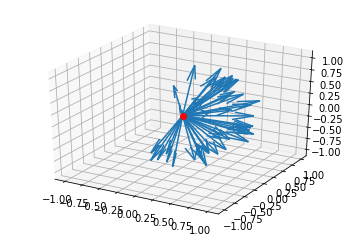

consistent
Sum of Squared Errors for each k


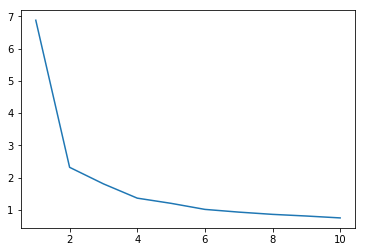

[[0.25988207463132695, -0.8253027602038515, -0.4374291288351222, -6.348619068437759], [0.3109654913123692, 0.8807670990538675, 0.13819012832251104, 0.5561290366911803], [0.38444737701414483, 0.4235266995741386, -0.7339042136496913, 0.10062885852270806], [0.4550063182936784, -0.5621857866778142, 0.6564443937599881, -3.3131246070008964], [0.3256250876359012, 0.277207810443864, 0.8677839095108737, 9.963199792232013]]
Clusters found with k = 5:
[[ 0.25988207 -0.82530276 -0.43742913 -6.34861907]
 [ 0.31096549  0.8807671   0.13819013  0.55612904]
 [ 0.38444738  0.4235267  -0.73390421  0.10062886]
 [ 0.45500632 -0.56218579  0.65644439 -3.31312461]
 [ 0.32562509  0.27720781  0.86778391  9.96319979]]


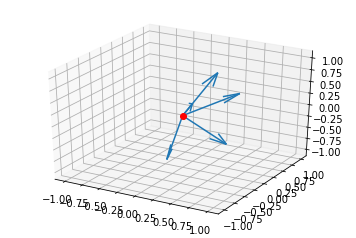

consistent
Graph of planes from clusters:


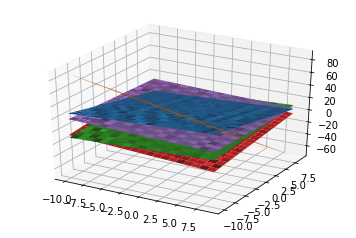

Geometric Solution:
[[[-12.50507556]
  [  5.58966671]
  [ -3.46203117]]

 [[ -8.58276178]
  [  3.10317756]
  [  3.5595529 ]]

 [[ -3.4113543 ]
  [ -0.1751549 ]
  [ 12.81721926]]

 [[ -2.68733236]
  [  5.86969358]
  [  1.84248188]]

 [[  6.79960261]
  [  6.14028497]
  [  6.9682597 ]]

 [[ 34.81836298]
  [ 23.46978677]
  [ -9.08122497]]

 [[ -3.57009823]
  [  2.02359314]
  [ -0.83948017]]

 [[ 20.47366976]
  [ -7.57260867]
  [  6.21772943]]

 [[-26.3556986 ]
  [  6.93096004]
  [ 19.15679701]]

 [[ -0.86177539]
  [ 13.82341687]
  [  7.38877074]]]
[0.4117539124232158, 5.920281606754807, 4.4568074610967]


Algebraic Solution
[-3.60220159  4.72614629  3.37283466]


Algebraic (Red) and Geometric (Blue) Solution plot


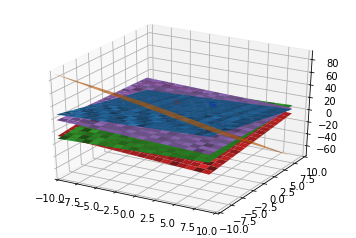

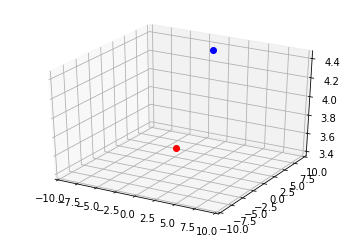

Component-wise error: [4.0139555  1.19413532 1.0839728 ]
Distance of error: 4.325828816985027


In [28]:
# RUN SCRIPT WITH NATURAL NUMBER OF CLUSTERS
data = normalize(data)
if dimensions == 3:
    print("Normal Vectors:")
    graphVectors(data)
data = resolveinconsistent(data)
    
print("Sum of Squared Errors for each k")
bestkcluster(data, 10) 
    
cluster = kclusteraverage(data, numcluster)
print("Clusters found with k = " + str(numcluster) + ":")
print(cluster)
if dimensions == 3:
    graphVectors(cluster)
cluster = resolveinconsistent(cluster)
if dimensions == 3:
    print("Graph of planes from clusters:")
    graph(cluster)
print("Geometric Solution:")
geo = avgsolution(cluster)
print(geo)

print("\n")
print("Algebraic Solution")
alg = algsolution(data)
print(alg)
print("\n")

if dimensions == 3:
    print("Algebraic (Red) and Geometric (Blue) Solution plot")
    graphwithpoints(cluster, alg, geo)
    graphwithpoints([], alg, geo)

error = L1componenterror(alg, geo)
print("Component-wise error: " + str(error))
ttlerr = sse(error)
print("Distance of error: " + str(ttlerr))

Normal Vectors:


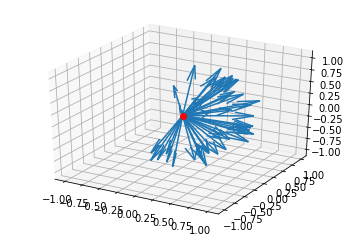

consistent
Sum of Squared Errors for each k


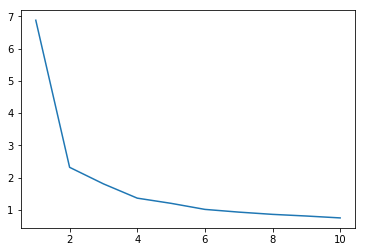

[[0.38267071410492914, 0.4699940221751858, -0.6848006224752363, 0.1678575611306921], [0.3639483379179144, -0.6849737076566316, 0.14597008321560329, -4.729688689004766], [0.3081148345615982, 0.6674674723745491, 0.4567036538633377, 3.8896296641547097]]
Clusters found with k = 3:
[[ 0.38267071  0.46999402 -0.68480062  0.16785756]
 [ 0.36394834 -0.68497371  0.14597008 -4.72968869]
 [ 0.30811483  0.66746747  0.45670365  3.88962966]]


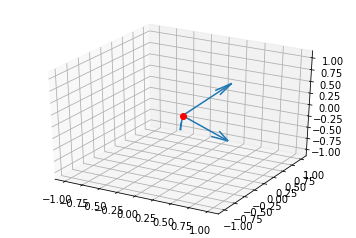

consistent
Graph of planes from clusters:


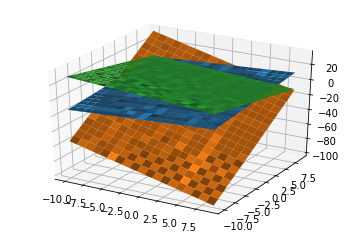

Geometric Solution:
[-2.95421676  5.77600037  2.06824556]


Algebraic Solution
[-3.60220159  4.72614629  3.37283466]


Algebraic (Red) and Geometric (Blue) Solution plot


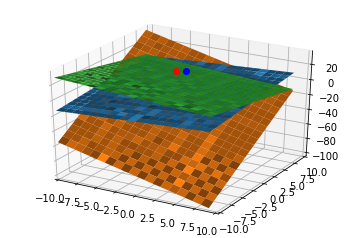

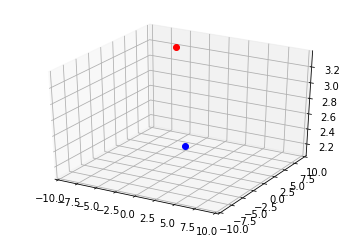

Component-wise error: [0.64798483 1.04985408 1.3045891 ]
Distance of error: 1.7955585933585747


In [29]:
# RUN SCRIPT WITH FORCED CLUSTER = NUMBER OF DIMENSIONS
data = normalize(data)
if dimensions == 3:
    print("Normal Vectors:")
    graphVectors(data)
data = resolveinconsistent(data)
    
print("Sum of Squared Errors for each k")
bestkcluster(data, 10) 
    
cluster = kclusteraverage(data, dimensions)
print("Clusters found with k = " + str(dimensions) + ":")
print(cluster)
if dimensions == 3:
    graphVectors(cluster)
cluster = resolveinconsistent(cluster)

if dimensions == 3:
    print("Graph of planes from clusters:")
    graph(cluster)
print("Geometric Solution:")
geo = solution(cluster)
print(geo)

print("\n")
print("Algebraic Solution")
alg = algsolution(data)
print(alg)
print("\n")

if dimensions == 3:
    print("Algebraic (Red) and Geometric (Blue) Solution plot")
    graphwithpoints(cluster, alg, geo)
    graphwithpoints([], alg, geo)

error = L1componenterror(alg, geo)
print("Component-wise error: " + str(error))
ttlerr = sse(error)
print("Distance of error: " + str(ttlerr))

## Testing Inconsistent Linear System Solver

In [ ]:
m = np.array([[0,1,-4,20],[0,1,-4,-20],[5,-8,7,1]])
graph(m)
m =normalize(m)
m = resolveinconsistent(m)
graph(m)

## Run Script Several Times

In [31]:
def averageerror(numcluster, dimensions, clusters):
    errors = []
    for i in range(100):
        data = makedataNum2(numcluster, dimensions)
        data = normalize(data)
        data = resolveinconsistent(data)

        # Always force cluster to 3
        cluster = kclusteraverage(data, clusters)
        cluster = resolveinconsistent(cluster)
        
        geo = avgsolution(cluster)
        alg = algsolution(data)

        errors += [sse(L1componenterror(alg, geo))]
    return sum(errors)/len(errors)

def averageerrorRand(numeq, dimensions, clusters):
    errors = []
    for i in range(100):
        data = makedataRandom2(numeq, dimensions)
        data = normalize(data)
        data = resolveinconsistent(data)

        # Always force cluster to 3
        cluster = kclusteraverage(data, clusters)
        cluster = resolveinconsistent(cluster)
        
        geo = avgsolution(cluster)
        alg = algsolution(data)

        errors += [sse(L1componenterror(alg, geo))]
    return sum(errors)/len(errors)

In [54]:
numdims = 6
numclusters = 9

# Tests
avgerr1 = averageerror(numclusters, numdims, numdims)
avgerr2 = averageerror(numclusters, numdims, numclusters)
avgerr3 = averageerrorRand(1000, numdims, numdims)

consistent
[[0.21615788690434357, 0.42104774599674516, -0.3182266327304661, -0.5444939187538567, 0.22478259297368108, -0.3278700039419328, -4.987583470404685], [0.3195559580521507, -0.20193517044631681, 0.46490266765312044, 0.3541524008805865, 0.288225539598394, -0.5562915987935948, -4.382433737789982], [0.39482922655059755, -0.2721171315982494, -0.51300835240169, 0.29798800755527816, -0.4199489210960633, 0.2213182436152315, -4.174517712762204], [0.0626850808462977, -0.5426089082416532, 0.4097288352969434, 0.5297677038132894, -0.14337450474673807, 0.2849433812826769, 6.4132858161043975], [0.4780208022691175, -0.31594577523606704, 0.2956903877162201, -0.4750830729593139, 0.4430230628460481, 0.19217003026672536, 5.583176922296664], [0.47066664105583467, -0.4403547793775982, -0.5626496673699948, -0.05393799006048394, 0.03425612823349513, -0.12223429196619576, 2.367727831783578]]
consistent
[[[ -20.17050179]
  [ -70.66745269]
  [  49.47311022]
  [ -96.23399336]
  [-125.02760448]
  [ -62.75

[[0.3860752676698536, 0.14776226720181174, -0.07550905598959365, -0.47498544110910323, 0.3102820823122018, 0.34256043434912836, 4.525132723325324], [0.4038127136135411, -0.28544527542992587, 0.43780394210936135, -0.272756657992756, -0.3791533645025558, 0.4067025477103498, -0.7515452700472807], [0.15087541993462036, 0.3283504454469814, -0.41990042732514554, 0.20248698182782654, -0.556107432799544, 0.1297126224094497, -5.978689183883039], [0.25566491684302184, -0.2844356464620103, 0.21207362095328486, 0.4793344002234961, -0.38026142947636576, -0.41710823550480397, 4.528539757179907], [0.28868794659603303, -0.3646841071268462, 0.26680473142064864, 0.07360060323348404, 0.43238340579588447, 0.40043780470403945, -3.6184769071340748], [0.19624738335953767, -0.0784649498657072, 0.06565860248400741, -0.2886112191808117, -0.3201047161690865, -0.6010652105031782, 5.964038020839319]]
consistent
[[[ 14.66130055]
  [ 49.99642337]
  [ 43.98435856]
  [  6.42726718]
  [  9.8364646 ]
  [-15.18219896]]]


[[0.41902188355448156, -0.11377932167303878, 0.07704276409766625, 0.5727922374642685, 0.27946469624378845, 0.005977968882278473, -0.13636619507674122], [0.34456902585469984, 0.11123853650128313, 0.34176682654773183, -0.5480277736303864, 0.12102528363305723, 0.48391207102458367, -5.260849825486042], [0.5767028918856167, 0.24779073576035757, 0.09951121949943795, 0.07619603107893341, -0.458108438028475, 0.2777699122831752, 1.0666417962194923], [0.1676303559463127, -0.5989137558328828, 0.24278160468116172, 0.26323712666789684, -0.459314569131832, -0.08827106592962213, -4.321398022931218], [0.24072800103327105, 0.08766987358148723, -0.31104482418038687, -0.4827635403503856, -0.2087933027051183, -0.44779268367255914, 6.19189508095929], [0.11141984706867503, 0.6444668330207692, -0.2766560596422443, -0.2612397697654383, 0.5398703649405129, 0.20269105833515882, 5.009896453797648]]
consistent
[[[  2.44048555]
  [  5.57719317]
  [-10.89699333]
  [  1.17445033]
  [ -1.18182574]
  [ -4.5695726 ]]]


[[0.45522229225565825, -0.5640359363308913, -0.04368102705545704, 0.23947850833405188, 0.1258144662075286, 0.4142150078398824, -4.281001410326312], [0.4907469301276037, 0.5122301008454502, -0.08563197101605685, -0.26315375347963976, -0.08425725442665619, -0.3630705645719639, -3.7539522037675552], [0.3692233812688043, -0.23749846170471717, 0.4017871960967741, -0.5102667012053886, 0.11729295646830162, 0.47097489725019714, -3.2392924754433907], [0.4209014448198925, 0.5045552037877223, 0.03959163406984825, 0.4064817649092071, -0.397936613224585, -0.08300408214658139, -2.7051215833045874], [0.5224473657716232, -0.37033112630459963, 0.3449861577240316, 0.20134827929447568, -0.22517431055788467, -0.3149718638623485, -7.448417299790325], [0.3564872820629426, 0.37006152945971, 0.606467687869439, -0.18243140385424766, -0.047926527706577036, -0.38591668939110313, -4.367778445014808]]
consistent
[[[-8.77653297]
  [ 3.03694895]
  [-1.89940645]
  [ 0.0357236 ]
  [ 0.57692987]
  [ 3.04940956]]]
consi

[[0.5502078235633094, 0.07754027976702027, 0.13267698023508462, 0.36644292781876014, 0.3585834182981107, -0.3705101343963721, -0.939956624334934], [0.33535657728914803, 0.2694903713782424, -0.5845232697520363, -0.05525366480447941, 0.20268039106458768, 0.324217169997286, -4.954093705856084], [0.46070537399299677, 0.20741418023043354, 0.5292688070770144, 0.25488268557457433, 0.14669007671065948, 0.42309329586509226, 4.858638270750473], [0.3364897240161516, -0.418280739996218, -0.2796744591948583, -0.2982035785815732, -0.16940534632469761, -0.4370852180655785, 4.991772728349012], [0.44037606319433154, -0.46647595296158234, -0.4841746482322558, 0.19388068586237442, 0.3600092189862, 0.05882657006700016, 5.318903749014484], [0.34143995865277427, -0.2270183104130343, 0.21455471666530135, 0.4395984549562547, -0.2809772937613903, 0.5924615657163688, 3.7247044663555613]]
consistent
[[[  4.51618351]
  [-16.16086016]
  [ 10.42447104]
  [-11.30957664]
  [  7.49506537]
  [  5.66261873]]]
consistent

[[0.38048577169710174, 0.00728420593022544, 0.2754785153919973, -0.46992522847071794, -0.23203278659811663, 0.42012076009134985, -3.4599975148129882], [0.3042150630172083, 0.459804203383153, 0.4402827548995458, 0.4660391954680451, 0.3504500555555039, -0.01004861948081278, 4.611492594980323], [0.22171897933825868, -0.43705015278095705, 0.3254513722607567, 0.24515868680484829, 0.5116658539311048, 0.15690386477330104, 2.0149609614343427], [0.19334481789867577, -0.17999855752942268, -0.09683824586099576, -0.43474171038840737, -0.09981281491832716, -0.6800310948414476, -1.811953712632035], [0.16746792305427138, 0.5413688487824673, -0.15740754784982797, -0.2889371468436399, -0.43543666029434597, -0.2840203728085981, 1.0734928952130045], [0.3575007412967901, 0.42621331422662023, -0.005839440952822406, 0.4328568759411003, -0.35571207185200426, 0.08011819361881435, 7.299914784895448]]
consistent
[[[ 14.48196317]
  [  4.06986665]
  [-17.69084665]
  [  6.97858976]
  [  8.26598492]
  [  2.54931196

[[0.5203218255283355, 0.1769908384807372, -0.05170263868168302, 0.09453193456595801, 0.5666725116625626, -0.341178205649987, -4.884925891363666], [0.19259078914336814, -0.4815403170103807, -0.17625605075191172, 0.4355244675997576, 0.10994540383770396, 0.6144589816985062, -4.835846007613166], [0.4250895476509628, -0.02897643125064854, -0.31554587399486544, -0.41461134617252926, -0.471930775395644, 0.20803172685639534, 2.1632302029474193], [0.39740551556782844, -0.15289365713038633, 0.320115792810515, -0.21283451468439693, -0.25556024001187994, -0.555985791951929, -2.739142167958505], [0.23071323044247397, 0.5296803003373504, -0.3542960256843056, -0.2552236678943689, 0.11113355282991717, -0.5435535810980286, -1.918394283006969], [0.27002559109799273, 0.38760643833428315, -0.1698401037292701, -0.049098761701850215, -0.10410300325951605, 0.7143621432720345, -3.901194163944967]]
consistent
[[[-11.22702807]
  [-10.41297155]
  [ -0.79566029]
  [-26.77792554]
  [ 11.81892997]
  [  4.12537767]]

[[0.19370473397824042, 0.21932674385090167, 0.5770600857185293, 0.4851452009619658, 0.08627644663970083, 0.2517811394808597, -5.901517537796234], [0.32717510333036687, -0.4410520127250688, -0.3353629805103463, 0.38451438072628513, -0.2200758236311981, 0.41545631037516434, -3.6584001762829432], [0.3213128948261003, -0.03491446187177538, -0.336299680038767, -0.521633356362302, -0.10623526023478068, -0.3107627668372433, 0.8795740799514253], [0.37665606548604286, 0.05301543386272159, 0.2828641894263364, 0.43841047516829157, 0.1703028922456217, -0.45648077570399326, -6.570519017467002], [0.14883167084876237, -0.24226299335610932, -0.07103309869526994, -0.14955844545922947, 0.05683005386640602, 0.7614308804406982, 3.616682337780916], [0.4491532139675252, -0.2023145815087707, -0.4722262355376837, 0.29880843744947105, -0.4293412397707642, -0.2843335421371142, -5.1013630753175105]]
consistent
[[[ -0.46198105]
  [ 44.08438754]
  [-45.83146486]
  [  8.81340826]
  [ 38.24959651]
  [ 13.46714159]]]

[[0.4306315060822914, 0.349244850898576, 0.17027244158170896, -0.18383550835236157, -0.6031112965800293, -0.009946806176736434, 3.7050938484496116], [0.2959792376809371, -0.2666020942986424, 0.33783146666757224, -0.33464197693628095, 0.6096256564611556, 0.052227061126115006, 3.5892286298256515], [0.3562219903975614, 0.047683785875167306, 0.09033908167666252, 0.3114905129579948, 0.6161328522332988, 0.348547183815737, -0.07029934189518078], [0.20823279507328774, 0.27068913459965405, -0.6010260072597646, 0.35285955481448605, -0.31782526320338705, -0.2759547920011116, 2.2377682417640528], [0.2367735356581661, -0.352318227128552, -0.38518706840634076, -0.3856041539282154, 0.36249695751078514, -0.3417821343143981, -2.018526147658368], [0.19939848699364754, 0.42547863918974604, 0.5635787289389742, 0.2289412441826444, -0.0946439270601662, 0.4353704374039079, 3.4828306458772036]]
consistent
[[[ 11.69359276]
  [-10.57368284]
  [ 24.58791195]
  [ 22.14546053]
  [ -3.21078851]
  [-31.19433887]]]
c

[[0.2393872748968115, -0.5101372199239842, 0.08049892743549503, -0.4016061908857533, 0.1379891413970561, -0.4477831183257413, 3.9913877211640547], [0.3159750533917699, 0.3386810862413428, -0.2830401644148164, 0.5043515566207651, -0.3033606416169291, 0.3970202969581473, 1.9471488402812134], [0.5355174148351554, 0.18120412230934113, -0.12556324281078127, -0.46434432283132937, 0.4504829708831536, 0.3446750530988876, 5.067282762032146], [0.373833018506466, -0.09971231443055611, -0.6091844642695567, -0.08554140441717709, 0.2015758491057955, 0.5538520478233656, -5.631756447521965], [0.3080571059102437, -0.48298904663734044, 0.12374646375118142, -0.4130428526480946, -0.5023453336406074, -0.25370550125620434, 5.548932478152368], [0.20397577157039704, 0.7158269804404285, 0.15424909472204573, 0.5192199185343567, 0.1867514571912433, -0.048681186411249786, -6.7863947421200415]]
consistent
[[[  48.95275737]
  [-135.29722224]
  [ 190.71853502]
  [  92.47118246]
  [  50.20181962]
  [ 138.21506415]]]


consistent
[[0.4889882463359918, -0.5796906636000573, 0.41876082029993267, -0.18660821797075125, 0.0748014011869356, 0.03043608023951479, 5.582258854361524], [0.42729712113774976, 0.26383665657916, -0.48009673796488733, 0.1278052991727617, 0.5516348137019694, 0.1207478719234673, -2.3106975932717644], [0.183452893005667, 0.34944125109477875, 0.5182328530125899, 0.44976219860386274, -0.231460435179441, -0.4703564384054092, -2.6951403821168722], [0.41199644770352145, -0.1506304858114279, 0.03643657081261492, -0.6110632398698146, 0.2540104465090045, 0.48179366869395623, 6.082845384930278], [0.3748439547066347, 0.45471309880090627, 0.04465866810531831, 0.40829448311970096, -0.4881580731553814, 0.3441747764700339, 4.598795024218052], [0.6153048814113404, -0.23776401464333285, -0.04724817079083319, 0.26531601151669426, 0.4723817870279555, -0.31524500211631734, -5.26045109526359], [0.4252369465646471, -0.033721121476304586, 0.36978032058676485, -0.45265128608212996, -0.4738813920293905, -0.354

[[[ 8.05973177e-01]
  [-9.02241072e+00]
  [ 7.70780306e+00]
  [-3.91827294e+00]
  [-3.68548438e+00]
  [ 8.88189443e+00]]

 [[-6.01131017e+00]
  [ 6.56792136e+00]
  [ 4.13455862e+00]
  [-2.25458999e+00]
  [-3.80969563e-01]
  [-3.62932511e+00]]

 [[ 1.08725404e+00]
  [-9.66566726e+00]
  [ 7.85523500e+00]
  [-3.98691644e+00]
  [-3.82182855e+00]
  [ 9.39810689e+00]]

 [[-2.68005938e+00]
  [-1.05026075e+00]
  [ 5.88061680e+00]
  [-3.06754507e+00]
  [-1.99571360e+00]
  [ 2.48425530e+00]]

 [[ 9.16464156e+00]
  [-1.25681917e+01]
  [ 1.61467530e+01]
  [ 1.77192186e+00]
  [ 5.97162283e+00]
  [ 1.55972037e+01]]

 [[ 2.85446650e+00]
  [-9.89138988e+00]
  [ 9.77597134e+00]
  [-2.52375344e+00]
  [-1.31877729e+00]
  [ 1.05276430e+01]]

 [[-5.10993759e+00]
  [-6.51285742e+00]
  [ 1.73507239e+00]
  [-7.94555134e+00]
  [-1.05203751e+01]
  [ 4.12908352e+00]]

 [[ 7.51375953e+00]
  [-1.04865124e+01]
  [ 1.48400333e+01]
  [ 1.33390676e+00]
  [ 5.28057025e+00]
  [ 1.35056887e+01]]

 [[-1.70610707e+00]
  [ 

[[0.29012364311789496, -0.44982954513167034, 0.47858178100287513, 0.3129707722384053, -0.26950510371333075, 0.32262101219908246, 4.0012263982893534], [0.25444351796214043, -0.389968312579153, -0.0796658939955343, 0.29096505895167235, 0.4964142061853063, -0.49907540581380994, 5.333152105921326], [0.6250107880615342, -0.03861488796908938, 0.6650958492406538, 0.15336597858293866, 0.04155343159160959, -0.04722961700972711, 3.905507967554747], [0.13109439950429677, 0.620176887764517, -0.10591451497473355, 0.2190954678293646, 0.4723301660770045, -0.2559519736501116, 3.13739674049807], [0.2382101127540564, -0.48065234884092206, 0.2431801585215913, -0.4523239310575181, -0.22106671306067083, 0.43850422213483997, -3.519699294150593], [0.42947563148970713, -0.3747916691075396, -0.16556147847047287, 0.6677031157871367, 0.030470748332912176, 0.07984592334528616, 5.811930754468829], [0.32274412928471774, -0.348379176544506, 0.0705479620475144, 0.35291780761418423, -0.698954133794143, -0.094731943473

[[0.13892208987617866, -0.13580910977413613, 0.08047525590782731, 0.5222534710770668, -0.5190597108194146, 0.457514364037986, -2.7728160754386155], [0.18277760710225743, -0.2867204974668537, -0.14804770759564437, 0.32331113306449216, 0.4661598623826451, -0.5603213543766419, 7.189225205185608], [0.5222238568350678, 0.14905484203512281, -0.46013841785818843, -0.08242930279273925, 0.3066900574218053, 0.396233419289132, -6.924678141654802], [0.28444610273050325, 0.24009645609107416, -0.16395122455988653, -0.6879107565424825, 0.3410619478047516, -0.23363202220376472, -3.966637007363133], [0.27825824093662915, 0.5772195509882981, -0.2111059181376712, -0.014423091869771587, 0.5169207533652163, 0.3683718959549595, -0.1773822123768728], [0.37293056789545287, -0.5733189838832501, -0.4502749992295171, -0.2831009516687339, -0.0045758284363068835, 0.12863578710362078, 2.804116289242736], [0.6444970648263602, 0.14992844194896016, 0.23350998226361816, 0.3812314953563671, 0.36196619323874785, -0.10150

[[0.5138196186004471, 0.08739356584306811, -0.5409393608499022, -0.44116392088634404, -0.22701504394482516, -0.10972266364022712, 3.9411726255377935], [0.35319095991336447, -0.4058292403451703, 0.32269330565716536, 0.3668737130872243, 0.4519939140634325, 0.05346757917319933, -5.516987471938556], [0.20515858350189983, 0.36745796945939696, 0.5236906648856096, 0.20091821298981558, -0.3799077464898423, -0.45930913005052654, -3.896613260920049], [0.22781338436387077, 0.6633398341025415, 0.3966607614503408, -0.09586421356816982, -0.02312915607155649, 0.31945218652385343, 2.7713605589480377], [0.20203192102398904, -0.19317958573740907, -0.34368233612793075, -0.10128287485474333, 0.530936162361295, 0.3946627831341726, 2.2796761719561416], [0.22308434711990077, 0.20376825053634431, -0.5717695770259186, 0.4953986976810125, 0.3375988087845202, -0.2383587973082664, 4.523817650823386], [0.20782916120888173, -0.5893457288657762, -0.34750178457768516, 0.13626276110003496, -0.0009012602956235752, -0.4

[[[ 3.90741802e+00]
  [-1.34100779e+01]
  [ 1.18836152e+01]
  [-1.69890796e+01]
  [-2.17614674e+01]
  [-1.52122435e+01]]

 [[ 9.66642938e+00]
  [-1.37820772e+01]
  [ 1.83520960e+01]
  [-5.50183128e+00]
  [ 4.06970874e+00]
  [-5.32207443e+00]]

 [[ 1.05168726e+01]
  [-1.38370110e+01]
  [ 1.93073079e+01]
  [-3.80548931e+00]
  [ 7.88424353e+00]
  [-3.86157594e+00]]

 [[-7.95311796e+00]
  [-1.26439548e+01]
  [-1.43805494e+00]
  [-4.06467724e+01]
  [-7.49601114e+01]
  [-3.55807927e+01]]

 [[ 2.45702208e+00]
  [-9.40543344e+00]
  [-5.76102157e+00]
  [ 6.29168108e+00]
  [ 3.00553142e+00]
  [-5.73011480e+00]]

 [[ 1.83901673e+00]
  [-7.69907755e+00]
  [-1.32792995e+01]
  [ 1.62114789e+01]
  [ 1.35586068e+01]
  [-1.68983446e+00]]

 [[ 3.29356440e+00]
  [-1.17151852e+01]
  [ 4.41584466e+00]
  [-7.13592244e+00]
  [-1.12792871e+01]
  [-1.11991056e+01]]

 [[ 1.51194968e+01]
  [-1.70924927e+01]
  [ 3.65908293e+01]
  [-1.44222343e+01]
  [ 4.87463354e+00]
  [-5.01343996e+00]]

 [[ 5.90633011e+00]
  [-

[[0.42840345365481003, 0.21488535297577452, 0.08568165288802701, -0.43398027802388206, -0.30001847416770006, 0.3063257044418232, -3.3942566351473626], [0.30590577928081003, -0.5206639596689877, 0.05568154454692555, 0.4284032291477248, 0.3300977706608013, -0.38449247390177, 4.5238935370563835], [0.1257044996955832, 0.6496385677160094, 0.0855215570361764, 0.49055262538434546, 0.4063031103280892, -0.017871284760047366, -3.66511454183684], [0.19187146303884314, -0.5165095811762253, -0.1673298497740506, -0.5445255241229389, -0.5061411075992627, 0.12691677458471148, 5.735544567542791], [0.5608904881600193, -0.44480924801910793, -0.0063564080726621576, 0.2996728711553, -0.3631741843346267, 0.10043711817282061, 0.7889997550155475], [0.292857787605235, 0.1978615009860075, 0.5947814724441195, -0.19638315472252735, 0.18821850837156173, -0.4452727016813493, -4.425164180143427], [0.3766392187437623, -0.38171944138908287, -0.013936333125221249, -0.5482293563940446, 0.40789191201321984, 0.01240477496

[[0.22167210196347717, 0.5935812839426177, -0.10809001977426838, 0.1730540599732682, -0.5800546099398393, 0.16641776974036293, -4.272766175409125], [0.26677784184839626, -0.40829244074274873, -0.18956195443868107, 0.5572505519603694, 0.39077870423763317, -0.28542715573351096, -2.184990831503066], [0.31524235269320466, 0.3755183175620689, -0.673527225165095, 0.03873874668939167, 0.2507447781126162, -0.0743803940679552, -1.4024305188968953], [0.15950319639487964, -0.018475043822165096, 0.539903631161072, -0.32380784371194643, 0.569217079601071, 0.13955873657818713, 4.264567167618064], [0.5201658885678594, -0.47206215338735813, -0.046215310709621454, 0.5087154421819946, -0.255681757016595, -0.18942756999778082, -4.512897401999361], [0.5639868295665573, 0.5029807826040158, 0.32715688738632387, 0.025759280474038887, 0.10863698310154182, -0.399246696751861, 5.603314164728531], [0.3767035372737689, 0.146947523968466, -0.4307249398779329, 0.401941781537558, 0.46294765065094257, -0.316234341892

[[0.5292913099577251, -0.24502117629369252, -0.21202160683582016, -0.629105993048486, -0.19976631447204088, 0.06838275183780206, -4.657407147928924], [0.1861806189696898, -0.265284241829159, 0.32091005584626153, 0.6541094956080232, 0.30948002016523, 0.13356767429331573, -2.375211833932109], [0.21252935277024976, 0.37448468796870266, 0.330121818418031, -0.5721921827257241, 0.453882397384283, 0.20264944631472934, 5.58527017659707], [0.28893023953442615, -0.38094683385450656, -0.24296625759201235, -0.3505237432864911, -0.2758365580352826, 0.5780085615229311, 4.1080080929354486], [0.16051135639391226, 0.36412848477069965, -0.362337999776422, -0.6708210016405324, -0.07675832446705107, -0.1456344127920889, -0.599708949765016], [0.15060658013196462, -0.25855063849620996, -0.282669210259303, 0.6709827574460274, -0.4722642487605206, -0.12200159970425611, -3.114704608087404], [0.4514968952814828, 0.11007573290304559, 0.06150197061463078, -0.3990561529250164, -0.6088960713588211, -0.3156213349697

[[0.39933828283043915, -0.06711868446964939, 0.3635682275928296, 0.10565504625299282, 0.6003792423398095, 0.4090340412547603, 3.365429051410305], [0.1279946914748471, 0.3004939066400725, -0.08624633800866649, -0.5482949114254677, 0.5880195340490979, -0.19538672514796673, -5.081647582779744], [0.5636420974028469, 0.1928794541338747, 0.1966720611175786, -0.10575456460505538, -0.5807698898275946, -0.11534680978918915, 0.053840578473928584], [0.3175351013463662, 0.4159760819439108, -0.08318480387175314, 0.4457438773001612, -0.3344660528553603, 0.5267777868921534, 3.657784194059166], [0.33938080559170225, -0.03110290333980234, 0.1311567069102306, -0.37963113253607966, -0.24686218519794087, -0.7092019318987206, 6.489490010996754], [0.22175842991457845, -0.39784484150877164, 0.23689958408704412, 0.4429253336070846, -0.445260753893093, 0.12006990235590044, 6.552793393682729], [0.15194118230507084, -0.49738650478200996, -0.6383485812619368, -0.3218038024313807, 0.12400031080716112, -0.315078943

[[0.7819041622604244, 0.12142508614083113, 0.4566037953247593, -0.07821934958998158, -0.0695194522071823, 0.23486303196070796, 10.798200504716673], [0.134188613595587, -0.21203347809883577, -0.46191154976338983, -0.49214087143455687, 0.459154186927403, -0.38792317023877854, -5.2585072477612], [0.46524521539237074, 0.4348009381367862, 0.21116755859990124, -0.03652754901143325, 0.43948329818938714, -0.4060820765805767, 3.7334529887219805], [0.40423781356855426, -0.4008052640081013, -0.017794530911928015, 0.24166519903896846, -0.24352828057420833, -0.5946995830360184, 1.3213945000201903], [0.18192674948440846, 0.22450694014207156, 0.3137731750958816, 0.5434741386907344, -0.37524844332423035, 0.3582337074223037, 6.9260721093311926], [0.30659913185290716, 0.4958933513285318, -0.14889990865223646, -0.016083651538017045, 0.30063198828645143, 0.6068921292343981, -4.00773490089238], [0.11576214248302774, -0.4924286629995968, -0.6359180171681882, 0.17473860849466571, -0.4193319376529679, 0.28770

[[0.29620690515937376, -0.43951261105922435, -0.157646307024629, -0.348048361247591, 0.5318436923333077, 0.3918724571573876, -4.332108148123783], [0.41619721512911967, 0.45963323904167686, -0.336743483918504, -0.4594769869983482, -0.44815433366794866, 0.07038064595867935, -4.384436567246807], [0.5607312873842266, 0.15165932596938078, 0.22074798727573422, 0.410181383851299, -0.3061703745750952, -0.4326691401152405, 2.259706555417937], [0.29811115373374436, -0.48072726840801916, 0.44489250930260277, 0.020263588547266065, 0.433421511621569, 0.324706904689331, -3.8357144892520565], [0.39865177918982997, -0.484161781734898, -0.4953879826476462, -0.05756266651282449, 0.05438316042852788, -0.38018653965408145, -2.921662865987722], [0.1401618166420033, -0.30864627980782855, 0.04076528037055404, -0.2881009442794453, -0.513322728718642, -0.6384757462271987, 6.215092424603946], [0.2028972857439452, -0.125200138796226, 0.41923078363325345, -0.5078506288295024, 0.41277437796642963, 0.35230472901333

[[0.6496436061039009, -0.3773245861891957, 0.21786861301741323, 0.09301187425823552, 0.2914632376653469, -0.2328393130416841, -4.179870786534304], [0.48919221088116305, 0.24950926527665165, -0.14317271083512526, -0.44901190668675334, -0.5859672936672938, -0.03563460211649279, -4.376875801948475], [0.5469632986932169, -0.22541781086673374, -0.1583206198388487, 0.2600669555246617, 0.17021477730739848, 0.5907547361130003, 2.1568167424207783], [0.2718245381337543, -0.1696972432329378, -0.06029451716402043, -0.5253325868153952, -0.29735125469795126, -0.6501368642443688, 4.634788696816846], [0.6958243028440547, -0.1552495162197702, 0.33472589904814953, 0.3518170547078891, 0.04615605764077365, 0.12601818131492817, -3.344263477092083], [0.15587025280371097, 0.25570163307114946, -0.2409300545650745, 0.5838416995067128, -0.2280775346167867, -0.4858215289458142, -2.3777639256688405], [0.34378252536864834, -0.47741494425355313, 0.23143324988756325, -0.2894626705011192, 0.006056452082226868, 0.6102

[[0.49919290977626796, -0.5135457354178699, -0.11845068824552284, -0.18557469054595346, 0.2777213693639906, -0.38985353759336144, 4.513852058028686], [0.2642117110049095, 0.011943572578190759, -0.07036971868818889, -0.5992530818993688, -0.3272188467503246, 0.5283484571485596, -4.519125545850628], [0.2710400279304237, 0.07166409318613726, -0.4129270839054843, 0.24062305831492334, -0.43635816815040807, 0.5017807517145053, -3.536756332171969], [0.136268258275766, -0.06817732598324053, 0.3843846187594749, -0.021797676880356717, 0.2847230885297095, -0.5491118171301594, 4.6770619347078695], [0.5194721396862874, -0.21828022456941176, 0.14932799398601054, 0.41406916889152034, -0.4636393579064726, -0.12852423368463362, 4.989344943431899], [0.32156154536280074, -0.04961280831092466, -0.7032497019755036, -0.30357366158077637, 0.0812397595201389, -0.3166327762595021, -4.724776675637005], [0.14513785004588967, 0.0827248747750706, 0.6057227874649442, 0.30416259047442085, -0.4329584997268242, 0.00065

[[0.3975367182024475, 0.44402769353633786, -0.18423251925779005, -0.24852509910834403, -0.4174954504531515, 0.3972567586616059, -0.6313140474152112], [0.5181881566657247, -0.06991898447245154, 0.7241811960574847, 0.28796370597140764, -0.08999255807899317, 0.0999450617466307, -5.000628762912767], [0.2381790888456314, -0.5731085587407626, -0.05845720972022822, 0.3917158424259382, 0.4450547589023199, -0.2724834038468934, -1.9815990492889008], [0.5506304901159035, 0.24005871896120654, 0.36790584224206024, 0.3449425409838217, -0.3049294588352957, -0.3903448332600401, -3.3179368523417647], [0.2592502073823602, -0.1345806962772109, 0.46703154504796374, 0.31847938162081335, 0.623668657601425, 0.26095788267497316, 5.340372533571081], [0.44811773983735215, 0.6772420306250431, 0.06701509394094471, -0.37190212294316227, -0.20715386346540668, 0.035997249627357765, -5.993632544543852], [0.31222852436895854, 0.4456171671776413, 0.2660819616747464, 0.2771473535073634, 0.21827642999871608, 0.5554741979

[[0.36405212243955243, 0.42589758954268453, 0.25884263142728225, -0.4883528772973038, 0.3963612773766076, 0.21443020252720313, -1.2773665895465174], [0.5033470018045515, -0.11542341148098026, 0.589722371103978, 0.27198704664157697, -0.18234206199330022, -0.2452025100808269, 4.890694311629686], [0.1666129073426972, -0.6958926024285729, -0.2996921519172312, -0.33387187732720947, 0.08828023842596518, 0.2912336067321365, -3.4304239678773434], [0.30599742022205295, -0.026984835257088446, -0.06541916194183808, -0.23042890186171036, -0.17494816179002365, -0.7339283915919437, 0.9082045808208238], [0.23730395864462178, -0.24478885887602983, -0.19752829802997982, 0.2553888385480217, 0.43345525037667176, 0.6342510119619069, 6.5761597912616025], [0.450373691999357, -0.02258237552970585, 0.49189077089740385, 0.23475716740971692, -0.03342422556125138, 0.5827580936684161, 4.78075449915336], [0.29037752241258763, 0.6427264667664911, -0.4308173085470757, -0.20151381666010537, -0.4119422377658684, 0.036

[[0.380270478478159, 0.5325733142672815, -0.05471784946313522, 0.4129491102078763, 0.42155799554472495, -0.2339191511191242, 7.029908667106028], [0.1930385897714381, -0.4196684548265536, -0.20450683892364105, 0.1793945952161804, -0.532505049002098, 0.5457056273488533, 4.812252645145238], [0.532336639807554, 0.4097344422401841, 0.42925279571607317, -0.3286441536370621, -0.3827096855108183, -0.04201380852762291, 4.358609661323441], [0.3589785684752961, -0.4415045387285653, 0.32889088587488235, -0.3251980856940544, 0.4484790210673415, -0.2053732129105728, 3.8057821470728723], [0.15123171851184009, 0.47410747121914437, 0.028828862544569258, 0.3236415836210994, -0.5380303216388671, 0.5216419407120935, -1.9715400339985814], [0.5271050769028488, 0.08996649069738727, 0.1276700879582866, 0.6129271021390361, -0.2519657033354808, -0.29434823451501113, -4.623882416992367], [0.4786559083784403, 0.46639592150561515, -0.25884553150730516, 0.28917243835804207, 0.026724759718846677, 0.4395931255388685,

[[0.28787096254328237, -0.3522704181970674, -0.25947959329063297, 0.4929515366595786, -0.29867565476032587, -0.491254626268847, -4.495046370304205], [0.3375813750622676, 0.5410569618762778, 0.48007599781261456, -0.4070788645438076, -0.12507044329191247, -0.08357152552709643, -5.449693468677276], [0.3699033329652786, 0.426197657769991, -0.4024298210354736, -0.039840378558125826, -0.46248360151050205, -0.4026924663697258, 2.277303821414553], [0.3565844334314618, -0.17645118733696724, -0.2834578134739732, -0.6491078530974511, -0.30615107025798854, 0.19606567628307411, -4.161582679706761], [0.4969170974460708, -0.02498345854251116, 0.48975396118571346, 0.26879044244251415, 0.39148210489770174, 0.3562035906480723, 4.623660000542724], [0.32354576101090166, 0.24266112448288282, -0.17620154977124663, -0.2327350610435589, 0.5334856723928301, 0.5429757258267289, 3.755055845377672], [0.5344361060087506, 0.1810899642549699, -0.3167531546048674, 0.4461851224130583, -0.3353332535556357, -0.370275079

consistent
[[[ 9.56590238e-01]
  [ 1.61519834e+00]
  [ 7.72213552e+00]
  [ 1.77242878e+01]
  [ 1.13919750e+00]
  [-3.40451531e+00]]

 [[-2.48198787e+00]
  [ 5.61056715e+00]
  [-2.92754228e+00]
  [ 5.42206848e+00]
  [ 3.52191134e+00]
  [-1.76817017e-01]]

 [[-1.28607297e+01]
  [ 1.76698835e+01]
  [-3.50717172e+01]
  [-3.17100117e+01]
  [ 1.07137130e+01]
  [ 9.56542126e+00]]

 [[-3.42650297e+00]
  [ 6.70802257e+00]
  [-5.85281582e+00]
  [ 2.04287173e+00]
  [ 4.17639966e+00]
  [ 7.09773224e-01]]

 [[-1.01584859e+01]
  [-4.53842607e+00]
  [ 2.18158696e+00]
  [ 2.26285401e+01]
  [ 1.54286156e+01]
  [-4.21900898e+00]]

 [[-6.12497998e+00]
  [-2.30536170e+00]
  [ 4.19217466e+00]
  [ 2.08488555e+01]
  [ 1.02431853e+01]
  [-3.92344060e+00]]

 [[ 1.48716458e+01]
  [ 9.31897154e+00]
  [ 1.46583940e+01]
  [ 1.15846138e+01]
  [-1.67498430e+01]
  [-2.38484397e+00]]

 [[-6.84788973e+00]
  [-1.61532092e-01]
  [-2.17958353e-02]
  [ 1.52080108e+01]
  [ 1.02936844e+01]
  [-2.47575768e+00]]

 [[-1.4371934

[[0.45327839670372927, 0.5616807828049888, 0.19746558369013945, -0.14176387769115747, 0.2837478010293376, -0.42731935482812494, 4.947605776515795], [0.26480806738498597, -0.6239988100513856, -0.39007797776032077, 0.03326833030495103, -0.045142724029572576, 0.17586582123126032, -4.20305765894091], [0.2440638329186963, 0.4355294771922886, -0.33567413358035825, -0.5490153049772754, -0.2111322488692826, 0.17439015062786012, -3.2208499405146163], [0.18699099337459088, -0.6198384338321559, 0.24012902541884623, -0.28709906369462723, 0.049769162830417116, -0.5144108335396876, -4.397238055629007], [0.25477447552554044, 0.6393991390084126, 0.36100091141851365, -0.2238339225409476, -0.4306631411968763, -0.06388588289675967, 4.003444250165276], [0.4785655364081598, 0.06042626091315034, -0.36086689722382204, 0.4626804895773984, 0.03869346039251706, 0.3717067455511352, -4.007144994085592], [0.043606614584897674, -0.5206611694027883, 0.46466794477057843, 0.6135383238783059, 0.11071322086430173, -0.21

[[[-8.55076470e+00]
  [ 1.03119176e+01]
  [-9.74637319e+00]
  [ 7.64362738e+00]
  [-1.00271552e+01]
  [ 7.28385732e+00]]

 [[-7.33450946e+00]
  [ 7.94490242e+00]
  [-1.04507806e+01]
  [ 7.74148827e+00]
  [-1.02300124e+01]
  [ 7.91229075e+00]]

 [[-1.55522427e+01]
  [ 2.39378446e+01]
  [-5.69139132e+00]
  [ 7.08028277e+00]
  [-8.85939020e+00]
  [ 3.66622621e+00]]

 [[-7.13080762e+01]
  [ 1.32447064e+02]
  [ 2.66002038e+01]
  [ 2.59412308e+00]
  [ 4.40033434e-01]
  [-2.51425535e+01]]

 [[-9.81407633e+00]
  [ 5.96784344e+00]
  [-1.43276389e+01]
  [ 5.66893187e+00]
  [-1.20096185e+01]
  [ 1.11526611e+01]]

 [[-7.22231462e+00]
  [ 1.48799796e+01]
  [-4.92888974e+00]
  [ 9.72014150e+00]
  [-7.94247279e+00]
  [ 3.21557153e+00]]

 [[-1.82027043e+00]
  [ 3.34556662e+01]
  [ 1.46610510e+01]
  [ 1.81641328e+01]
  [ 5.34734233e-01]
  [-1.33278123e+01]]

 [[-3.59016316e+00]
  [ 1.09304212e+01]
  [-4.59641133e+00]
  [ 1.08712159e+01]
  [-7.54266347e+00]
  [ 3.01906970e+00]]

 [[ 7.68230878e+00]
  [ 

[[0.34530146369079495, -0.2875141212589869, 0.5018139470113913, -0.3814598204492545, -0.1928234890455037, -0.48641480601482345, 3.479436418473683], [0.521063790703226, -0.2459788453906561, 0.43282101037821985, 0.0024089914231798237, 0.020403473495339657, 0.48176227800193056, -6.067140006723176], [0.6174336498465319, -0.18339747672336126, -0.3826465734806542, -0.5329859092307073, 0.1616887752992236, -4.0265901627908884e-05, 2.497366537664983], [0.23861366557743585, 0.3335017641388589, -0.5252268161264902, -0.3081596642537605, 0.1621970991824765, -0.44427011988973714, 6.110322869707931], [0.26034136078691983, 0.4740006311549788, 0.3776430633131268, 0.021354551380368347, -0.4922905575667661, -0.449794709426931, -4.865874961870528], [0.3256893638167282, -0.3294964275451312, 0.576698805092312, 0.4284697066146125, 0.18317453582348664, 0.006887161452606136, 3.3829951841637866], [0.4765129855943644, 0.2086039299438788, -0.4804801205637469, -0.5894185738938267, 0.04951919235533889, -0.139135610

[[0.36601317997390487, -0.4608833847783863, 0.5448698461063601, -0.08984171164734683, 0.3252320462063133, -0.36407610151353553, 3.4197622859304553], [0.26619840279357265, 0.21928292645392997, -0.014155171429796234, -0.5905553205510576, -0.5675311833151613, 0.04452380272970982, -0.3657549747498343], [0.5442719248173742, -0.4160513700882976, 0.5131540212735138, -0.06553841002506978, -0.0999078444541016, 0.33448958123035655, 5.337334696290411], [0.21678718867680172, -0.2165777352374323, 0.009380437432619217, 0.655467795704948, 0.4400424350114848, -0.3043529900967724, -4.909659572210242], [0.3211607269260828, 0.5970173409083064, 0.13811842787047018, 0.10853437713999828, -0.3454178398797019, -0.49923630817626663, 3.766980151728815], [0.5806070647682104, 0.18668828392078457, -0.2604106820537727, -0.2757554652191231, 0.5344993162707172, 0.25850497460422794, 4.0263998042753615], [0.4222703496392458, -0.20033494984684444, -0.20056481106916726, -0.6369125301084836, -0.30651494505188626, 0.115374

[[[-7.07283035e+00]
  [ 4.13682557e+00]
  [ 2.37577128e+00]
  [-1.54349960e+01]
  [-4.19546940e+00]
  [-3.06118798e+00]]

 [[-1.09309618e+01]
  [ 3.45526005e+00]
  [ 4.11438445e+00]
  [-1.39454263e+01]
  [-6.12414275e+00]
  [-3.39200506e+00]]

 [[ 2.58650446e+01]
  [ 9.95552828e+00]
  [-1.24672232e+01]
  [-2.81518408e+01]
  [ 1.22701185e+01]
  [-2.36916146e-01]]

 [[-2.07522844e+00]
  [ 5.01968640e+00]
  [ 1.23671610e-01]
  [-1.73644990e+01]
  [-1.69717668e+00]
  [-2.63266652e+00]]

 [[-8.41535734e+00]
  [ 6.10587298e+00]
  [ 1.53027478e+00]
  [-1.43162303e+01]
  [-5.63864153e+00]
  [-2.52165877e+00]]

 [[ 8.21169597e+01]
  [-1.26675387e+02]
  [ 5.85457078e+01]
  [-8.97593655e+01]
  [ 9.16806069e+01]
  [-3.89044126e+01]]

 [[-8.52541092e+00]
  [ 6.26728554e+00]
  [ 1.46096525e+00]
  [-1.42245196e+01]
  [-5.75694550e+00]
  [-2.47743089e+00]]

 [[ 1.65987754e+01]
  [ 3.24624747e+01]
  [-2.41650460e+01]
  [-1.80033524e+01]
  [-8.11017707e-01]
  [ 6.13270576e+00]]

 [[-8.30299495e+00]
  [ 

[[0.079968081851187, 0.6169760498449605, -0.39007802534112956, 0.032030681849897685, 0.21528397077424577, -0.022304571188976226, -7.107057427270512], [0.19970086633633233, -0.5470726867917883, 0.06246584161562562, -0.3926218232166795, 0.44770308791430924, 0.16651865335563087, -0.6538426525377979], [0.44696749027373917, -0.30992015364426556, -0.4214572669812199, -0.04972019628332071, -0.5861637567074449, -0.2331583943095653, -3.165284944793522], [0.5025788579710831, -0.545913934426504, 0.16979974790571736, 0.32717352305662134, 0.25400639400220393, 0.10701376332909009, 2.512469009636226], [0.21909430599160196, 0.4979094438224382, -0.1906080758637136, 0.47388632414440457, -0.46943991711375643, -0.06413655344247278, 0.268491480493684], [0.2582797112205843, -0.40439600235037937, 0.5889896158295146, -0.16639969138843685, -0.4136333545688001, 0.11150917166291811, 6.686949206451146], [0.34582835654745897, -0.2647539027333431, 0.5418992266948566, -0.33428170032015553, 0.16408894136899516, -0.48

[[0.15533320878166007, -0.5760441163670855, 0.15210094967206472, -0.3862387507294194, -0.2819105651115439, 0.5100676823591829, 4.486033072743015], [0.29534552982879164, -0.5255718527278682, 0.20904284537470028, 0.21877370304168223, 0.11878481110623519, -0.5695507605516618, 1.7376049887004124], [0.4240261611722127, 0.008947605421709762, 0.706104524933941, -0.24735802836851759, 0.03327204534996346, -0.21263735837907627, 4.874090115631027], [0.34418398300161834, 0.27652942976298206, -0.46442766624022686, -0.23850334549643695, 0.06161225622045394, 0.5358670418044945, 3.1661257711003836], [0.35255277671926727, -0.329242591909038, -0.5291485606619417, -0.23159960216818493, -0.1308592746214195, -0.4936947708154976, 1.6727080874665698], [0.22924991814660606, 0.32021819014357056, 0.052095025352154774, 0.47577588953763317, 0.3831695400270949, -0.4188013141115111, 3.8695742584114776], [0.09082774705744598, 0.5158173272799815, 0.08205965774038414, 0.14252518790957472, -0.514221135385989, 0.5318018

[[0.313607655772786, -0.47520295744133934, -0.5575794629076972, -0.03606281048922674, -0.2211192206764942, 0.2586454251689326, 4.755046838982991], [0.28301330922444284, 0.10804702904623818, 0.4433506990597843, -0.3343072410836724, 0.2841354811074726, -0.34619209754992636, -1.215639365703543], [0.6252384056990903, -0.11277368579198749, 0.35015198117090096, 0.07975414149420645, -0.5429087869794206, 0.14785350804310474, -3.968183572062702], [0.40963395025879057, -0.3735286688786596, -0.08876995425492298, 0.4552530144037681, 0.3719884097257539, -0.43935955417010436, 3.4314656063662348], [0.306145382496916, 0.24951523538031384, -0.24072037358058532, -0.4795991863482797, -0.2987492245494835, 0.5462019221515027, -0.7954485385548676], [0.27514845283739886, 0.3675506497865919, -0.46209955931665697, -0.3324914610813071, 0.2328889567071701, 0.37401559545991653, 6.843487327997993], [0.5276615985363979, 0.12947047717564747, 0.1665577151070983, -0.6131601290326723, -0.16765675886647874, -0.210611116

[[0.13013476003454832, 0.2753945316717083, 0.2997187642902066, -0.10746457863885775, -0.053884015562497375, -0.6881110150010583, -9.432766548278591], [0.5400762807879224, -0.1569357102131319, -0.16375612986392982, 0.08211869276330061, 0.4731111249852569, 0.3800031422798431, -5.976793038259349], [0.5425232431321803, -0.2984452474137687, 0.12286724190423462, -0.26369746929127147, -0.49847383486904534, -0.14262156282423272, -4.38134503424467], [0.36868930324579663, -0.06011345180581355, 0.20044332638339182, -0.3354107370727087, -0.20999769468779772, 0.6120189234558753, -3.0722043572545403], [0.3497735950179747, 0.3404282027620122, 0.4949501373684245, 0.1765661816418379, -0.45944972903487946, -0.27013633825876926, -1.192141263825894], [0.2566996355577809, 0.4865576939133628, -0.2612036435634253, 0.20037408556328892, 0.5579056406675342, 0.030896933719285164, 5.508767712383972], [0.23652146051646644, -0.10911794253445864, -0.31498962711449635, 0.5100487460942355, -0.3089907092840463, 0.17976

[[0.32378895389016243, -0.5344458143252179, -0.013965225762541158, -0.09737340072479891, 0.2995874971654232, 0.5837433612851453, -4.450713603912452], [0.5032086197650332, 0.41331809853303136, 0.6583532497923267, 0.0033796807032725057, -0.04874915003197318, -0.18813527147477857, -3.7539941306923046], [0.4552242072131897, 0.16806208087950628, -0.19053918697136166, 0.6133855264262162, -0.3226066776255698, 0.09868213511185625, -5.322320218500299], [0.20739420296510044, 0.2212040301264607, -0.5555280046178731, -0.228039747272018, 0.585707736556948, -0.2495149179104409, -0.5174976302144931], [0.2643022918225395, -0.3577207163333331, -0.4020548401224704, -0.5768366882521305, 0.40544377303494983, 0.011249513453498942, 3.3332386400623593], [0.5706867894233774, -0.6497997155622037, -0.0459441777280206, -0.21263972218428073, 0.12335040817753182, -0.13625396174201088, -4.954283160440652], [0.1340389245881125, -0.19231997015015984, 0.4958553247495006, 0.28947390294827663, -0.5797179666044324, 0.203

[[0.30849025700648175, -0.37661796820625787, -0.4241758813725969, 0.4399830050158239, -0.39315883338410107, -0.3208697935122181, 4.388216930848601], [0.45521762242207836, -0.18786329936434878, 0.44814022699217354, 0.2073325055218204, 0.2560730316934993, 0.5330760349067526, -4.364309045677342], [0.439943894421247, 0.25696629720870307, 0.4874457613372717, -0.2847795330069106, -0.2762304665584438, -0.3897415174282405, -6.035538712893957], [0.401764901485219, -0.033876670475996115, 0.07968257464108836, 0.4471682002619487, -0.47675274526913364, -0.5113565936161298, -5.140499043430175], [0.3578355421031135, 0.2888262697795069, -0.5254844242425769, 0.0018171497030651795, -0.4282167215817075, 0.42128936409603157, 5.278009474209198], [0.48236826309556413, -0.1522784951565805, 0.054363793039430446, 0.4700446033910065, 0.5097213331367421, 0.33582098323435083, -7.037380590711721], [0.3786315131295956, 0.23460879052639555, -0.257690394880146, 0.4157486948629524, 0.47695862580563236, -0.450744775143

[[0.6520228587200323, -0.14136536432254534, -0.580400652555118, -0.21915047742108806, 0.025182338722793615, 0.01963475200198594, 5.667467718821533], [0.1341213076625308, -0.5223042016198951, 0.4634062399022207, 0.24523518634525193, 0.331615050757327, 0.16055569685326515, 4.877514392825075], [0.453796838522664, 0.40152064305108914, -0.38976215992849994, -0.49663766028551315, 0.23468830407950783, -0.1754010964703811, -2.9018863047274923], [0.5126273287965297, 0.6308192193508639, 0.055880568474277234, 0.11831552934926587, 0.2817432168519275, 0.3248844044041956, -4.471908298928232], [0.3685166503111305, -0.10891410472286014, 0.08805827542199357, -0.5092518372677992, 0.27258481851141647, -0.560608952857498, 0.2959370521245921], [0.09933170362077387, 0.3964658095471638, -0.04463335906837197, 0.20362761239653948, -0.5212629805727828, 0.5205280127863735, 5.227789903187641], [0.5600270827517603, 0.44330208770085244, 0.3004809011302203, -0.20054244292342743, -0.20595730195686232, -0.389990364956

[[0.42551235587770286, -0.2284265616952495, 0.1733620586678472, -0.47943313328148707, 0.2407278165272139, -0.519218673699745, 2.780437381323851], [0.3995300238548958, -0.12524896577858385, 0.5148249195110314, -0.5416162370071588, -0.30032121590770444, -0.13390162897683777, 2.956591187045715], [0.41499987458515813, -0.49307405392157727, -0.34154659916629615, 0.13804902345706452, -0.073460115577459, 0.4310513760288034, 4.767293050934181], [0.20964648317353946, 0.5491322479467168, 0.3065248451593156, 0.22887703750047253, 0.4444603655409323, -0.16470679384729428, 2.308993304738528], [0.18878494656883504, -0.4964245065039079, -0.23714745783632996, -0.3319973931977024, -0.505751188182681, 0.22433177990430456, -3.4689184162590627], [0.16093265663896797, 0.08304991444591085, -0.5257464800336826, -0.41090313558079716, 0.31035042252691664, 0.5296719171250587, -4.85657330852434], [0.11498905358038441, 0.12403844720233383, 0.5244129280349752, -0.48420329293127806, -0.37342514729725884, 0.414853629

[[0.26888589734604185, -0.6140004688969578, 0.3199994229654822, 0.009785352878130177, -0.5254749397076398, 0.0666244414870868, 6.608784582871279], [0.44665188044227305, 0.33365565827728116, 0.16243650718763591, -0.3022674523450986, -0.004905888992636421, -0.5659496614747466, -2.415656662838567], [0.19552629689093526, 0.5498000759318198, -0.17688319174491887, -0.0931169885791831, 0.6708042328599712, 0.11834299186189576, -5.797963284772109], [0.3453742909374591, -0.3630740819935458, 0.3152151251585598, -0.5657181061649245, -0.36121265461773294, -0.3066793726690174, 2.843503360320097], [0.5009771098463333, 0.16559776691975997, 0.25262024762095736, 0.5632525846037277, -0.013320911333071353, 0.41263679813950715, 3.1540550317808553], [0.4563268473944105, 0.5022591596363952, -0.27783232752966747, 0.32091483712187474, 0.24733611051245052, -0.35793660082684653, 3.4960041911465325], [0.10840484530703734, -0.32726728938634897, 0.02521618411938513, 0.19040381631963024, -0.7825765837074241, -0.2919

[[0.42139534106052656, 0.48877450403638173, 0.45551620157940076, 0.38621323494745763, 0.28444307444780403, 0.3083329894474419, 1.1589890629922164], [0.49046605323198644, 0.3258513844708445, 0.3328984143167567, 0.3974491579172939, 0.49814212527005464, 0.28891645313890946, 1.1845157040422936], [0.2513184740658273, 0.4556140260370335, 0.40280167453624804, 0.42074326894387004, 0.49107482252236817, 0.31313241545132187, 1.1803992907889003], [0.3903252098742464, 0.4544861446988271, 0.30698273975143053, 0.2869228631676845, 0.3939393069395045, 0.5098198110528842, 1.1733506412742296], [0.3590753227274227, 0.3476418559255712, 0.3262790867555932, 0.5215057953175728, 0.2945044977308595, 0.480091115193913, 1.171573248483344], [0.3819459799019672, 0.24933553000737224, 0.5192687463751879, 0.3400057184216818, 0.3901575349489237, 0.44846092581004715, 1.1857296360616423]]
consistent
[[[0.47364367]
  [0.41071649]
  [0.50581208]
  [0.51709346]
  [0.58989927]
  [0.52133046]]]
consistent
[[0.3076076112611895

[[0.4346023416159479, 0.2969354371033185, 0.3414874623714681, 0.5198212393648525, 0.3003854136122845, 0.438710598765105, 1.1648072079606466], [0.26090795202243866, 0.40427783056237404, 0.5087795973762959, 0.3227357831500457, 0.43697218766291973, 0.40233933457737864, 1.166270101432344], [0.5057779391888582, 0.2790135400326832, 0.48541398797863033, 0.30224833959645586, 0.3697756907833229, 0.38708510821986736, 1.1845953466654606], [0.3984281881505766, 0.47745464980573843, 0.2909576360313552, 0.316234600868349, 0.34739562103961263, 0.5043090513700221, 1.1848659639725465], [0.3976660341979539, 0.5135347876387621, 0.4187215998711818, 0.44144239940283825, 0.2953601378762255, 0.26549666050733617, 1.1963085420170116], [0.344526153921526, 0.3555181840648288, 0.3201592745279452, 0.4528247065044908, 0.546446492842508, 0.29910228949300893, 1.2254796015590543]]
consistent
[[[0.64800957]
  [0.56664855]
  [0.3681883 ]
  [0.46116398]
  [0.69019323]
  [0.32400447]]]
consistent
[[0.3091748163223603, 0.51

[[0.255973765285466, 0.36930598444205487, 0.3731915582045153, 0.5289272303060367, 0.45916474609976304, 0.3325406446873892, 1.2235042951673967], [0.32279561389446276, 0.38725076159031896, 0.5259429563231582, 0.3617161932180896, 0.27755088386139437, 0.45371685963069686, 1.189243471440737], [0.4806304069958387, 0.465366039791721, 0.3149971860411961, 0.4558650625698184, 0.31968727990314233, 0.2991895406922597, 1.160197571913214], [0.32031203445297235, 0.505922861092742, 0.3193274737946156, 0.27876744364428346, 0.46663003612713444, 0.4364842249285735, 1.2189221156987697], [0.4528497729968566, 0.26330384457823136, 0.3235259270107457, 0.395697527996112, 0.37947481079526785, 0.5175898202815788, 1.202833657834761], [0.49165938527509456, 0.33796024590536106, 0.45929488953908415, 0.2990990833085858, 0.4471088510135107, 0.29821342054221045, 1.1874771816630079]]
consistent
[[[0.3411048 ]
  [0.44995296]
  [0.49828652]
  [0.50796155]
  [0.69959582]
  [0.5838665 ]]]
consistent
[[0.47748899063694156, 0

[[0.3017587368634868, 0.38169968862158005, 0.29689018010221224, 0.45579249500190777, 0.5238618093008758, 0.36900037938900726, 1.2024712467131011], [0.39126657262688225, 0.26155143971270584, 0.44332486049087905, 0.513660599866651, 0.3140971640105602, 0.40632086372437376, 1.2113738302548267], [0.49361549555551343, 0.32858062404824356, 0.34836951720014014, 0.2905299553673619, 0.38559644178330826, 0.48986229669524545, 1.2261029648889972], [0.38329741284699526, 0.3790221142895507, 0.5015680786677277, 0.28917633311186525, 0.48907211241207443, 0.2859315049998426, 1.1725129370112184], [0.2987986935100282, 0.4981934218582782, 0.441224227584078, 0.3233431714212583, 0.30340031726135197, 0.47122062357783295, 1.153378923854003], [0.46772744367650626, 0.49862886254504923, 0.33795435051909833, 0.43451530847972814, 0.31132376573261367, 0.28364989672546803, 1.2251172380505166]]
consistent
[[[0.73820397]
  [0.42173672]
  [0.33476016]
  [0.60033939]
  [0.51510309]
  [0.47662537]]]
consistent
[[0.47698403

consistent
[[0.4609594772093375, 0.3085995412402891, 0.3440357286054912, 0.3424451851995438, 0.3359604513109377, 0.5358725617969264, 1.1733229837825376], [0.4411252280081787, 0.2680404730625016, 0.32653820098189645, 0.4949047215291285, 0.4625174190065319, 0.3438911396917748, 1.1384745037394113], [0.5187047232802193, 0.41862738662125126, 0.4485208108471667, 0.3031270149068682, 0.3645861891540576, 0.27264505570658737, 1.1815467190855626], [0.33833472133529296, 0.47795671183145005, 0.3819755939457402, 0.49196141225864837, 0.27781731938769144, 0.3731849737836393, 1.1587060019140119], [0.2731404987797362, 0.3302651737478929, 0.5368129311905658, 0.36390682122237095, 0.4440621374952207, 0.37986449945743267, 1.2248803034579925], [0.3006827077729939, 0.493529296656235, 0.28937424298330455, 0.3467962563550168, 0.4872871567067806, 0.4193034640096672, 1.169920084751889]]
consistent
[[[0.40780439]
  [0.47936899]
  [0.7413366 ]
  [0.3168037 ]
  [0.51484544]
  [0.56152669]]]
consistent
[[0.3361105590

consistent
[[0.5383110096907655, 0.41896841805182705, 0.3631620956169727, 0.32825413683718946, 0.3890943655120169, 0.296221139942181, 1.2121706632346483], [0.3142477081370459, 0.2817640784204136, 0.5067873620986504, 0.4071450757452569, 0.4752996487503789, 0.3477289647032921, 1.1538286799909139], [0.30026364109284737, 0.46589043152135584, 0.2840025638277733, 0.48833389630505897, 0.4610350686667067, 0.3405286586212796, 1.1957089565162813], [0.34078220367768525, 0.509042459281824, 0.49283813701097023, 0.347397090493693, 0.28969350929210447, 0.3479972713622385, 1.2063845326141882], [0.42307890316606395, 0.3036003710491169, 0.3526116689888743, 0.471861170873097, 0.2814800343626438, 0.497122702542902, 1.1814646891373086], [0.3979075262949792, 0.37987291568897064, 0.3111840220017056, 0.276007269708868, 0.449721792368602, 0.5224631869126365, 1.1716806985465718]]
consistent
[[[0.59354873]
  [0.65082127]
  [0.46445204]
  [0.52364853]
  [0.39577993]
  [0.42342142]]]
consistent
[[0.386918951802615

[[0.5297333275280416, 0.30812580132073664, 0.3328672610801259, 0.4782487030942749, 0.31796933548800815, 0.3615279370253309, 1.210823468214638], [0.29707466136367927, 0.5183618036242817, 0.37427007215370345, 0.3975444172146208, 0.2870338512337478, 0.45587178933737266, 1.1477350219355955], [0.3927518758701765, 0.47536636909667007, 0.299041894119498, 0.4094956832803583, 0.48598798438163143, 0.27449556296246214, 1.199620126730385], [0.2820668984155892, 0.3134296223061509, 0.44712615063050926, 0.5230253636895761, 0.40146290156154124, 0.36784316171158193, 1.1942750383589396], [0.4142663635234403, 0.3754943679304664, 0.5321006453785407, 0.27191487816798654, 0.37923019356029225, 0.35933977565616515, 1.1899676441753217], [0.4310220483980698, 0.33712488329804063, 0.31751025993085585, 0.2871749556980062, 0.45271532395412056, 0.5110774132316633, 1.1761175637408943]]
consistent
[[[0.61888893]
  [0.41242994]
  [0.53051637]
  [0.56273081]
  [0.55569491]
  [0.36922823]]]
consistent
[[0.301559284935788

[[0.5249960649325294, 0.3640005714236865, 0.4289071102237858, 0.27924074446038477, 0.32807987855119836, 0.41218018502793496, 1.1925041788164026], [0.364881989294972, 0.32916383295384816, 0.4957392571961535, 0.47150666079630477, 0.40680065002023397, 0.27329458012880276, 1.1999488474296032], [0.40259663143691626, 0.29980403548619894, 0.2849575747905719, 0.5082189271088645, 0.39366190506324417, 0.44794527002721485, 1.1769680851426845], [0.30154632365363115, 0.31520778140911004, 0.44204968083306717, 0.2863764495370523, 0.4772253001450104, 0.5051144111736249, 1.172017039391741], [0.3162631744059497, 0.5305218825752013, 0.38035205446954423, 0.40898225274058225, 0.2704601270189392, 0.42447352836042673, 1.2071079245040324], [0.3948769116029852, 0.48478940007114835, 0.3066626037144676, 0.3554414234282042, 0.5049806192900981, 0.2867278280614563, 1.1585747325041753]]
consistent
[[[0.4808966 ]
  [0.53157408]
  [0.61938171]
  [0.5453504 ]
  [0.35630667]
  [0.51361947]]]
consistent
[[0.3530121012794

[[0.4497785716537736, 0.29778371739633647, 0.41493571455876094, 0.5303349975287204, 0.3292137932704139, 0.31061839538271724, 1.151364453283733], [0.35262795052109264, 0.3666297713978129, 0.252631583408737, 0.44456979674467273, 0.5032523062358711, 0.41667870175635646, 1.189779849063387], [0.49776910178671047, 0.2996387797019299, 0.455339083884287, 0.264023648324931, 0.3888597186391618, 0.4307852158861873, 1.1816924633128871], [0.47999887061923285, 0.5311750835094405, 0.3280038411500069, 0.32948221156795565, 0.343946137033086, 0.3080735205639363, 1.2243333127939997], [0.27316302531768993, 0.4165432350650475, 0.48737654020876897, 0.3499373569947122, 0.4863168191019409, 0.31886032982303936, 1.1755166987553498], [0.27295555977074437, 0.4256109188179281, 0.4136705803656145, 0.41754467958504804, 0.29297221903389403, 0.5058299472833273, 1.2119292826621981]]
consistent
[[[0.5014864 ]
  [0.72888664]
  [0.40072417]
  [0.40880417]
  [0.41948019]
  [0.60389034]]]
consistent
[[0.29054463887041515, 0

[[0.3962524685262079, 0.285601406083563, 0.2729831086154166, 0.4617962589779233, 0.42090212954103073, 0.49306399445531557, 1.2061637535966019], [0.5015715741266362, 0.360155490589045, 0.40399801346679, 0.41182559786185985, 0.42212976560390314, 0.2402810043801376, 1.134746043293336], [0.4858072348460912, 0.3515328416907532, 0.4560045086473483, 0.29008118306136615, 0.29928529981275126, 0.45266944419823, 1.182678029254396], [0.270346383286559, 0.32731909578030893, 0.5129610238551726, 0.45309449836081395, 0.4054408208758486, 0.3657957098054546, 1.201782522064505], [0.3249089118455321, 0.4855664643993218, 0.3652490605719517, 0.27454189905465887, 0.49556570110377646, 0.3887699024656132, 1.190813699132935], [0.36243919203111247, 0.5254947920216264, 0.3082945188453131, 0.47280551619606326, 0.2923949826825261, 0.36994445007816307, 1.1813240715744093]]
consistent
[[[0.32875982]
  [0.48053911]
  [0.50506542]
  [0.51179459]
  [0.49262003]
  [0.72421683]]]
consistent
[[0.31955045607498167, 0.497352

[[0.5091506383957769, 0.49193609102346514, 0.2879579834829148, 0.3012230778582089, 0.3781669157123934, 0.3571614858297784, 1.2006144364866906], [0.279626870922595, 0.45831009688061164, 0.3096440326441783, 0.38973888700805576, 0.3854332309262515, 0.5117076190432561, 1.200609762703313], [0.35940973689537326, 0.4352968560643766, 0.4552506228601533, 0.4958593875032955, 0.32697715724593923, 0.26193649822280274, 1.1380692466094227], [0.4350055926972585, 0.289389006574076, 0.46329301190988725, 0.3719579243356061, 0.27830201335273985, 0.4914800946547905, 1.2377219218291184], [0.34201558758191974, 0.3680767328809952, 0.513914940365666, 0.2767362842920483, 0.477974572656834, 0.3571276627901697, 1.1916422223265117], [0.4197941964435701, 0.26754643587297966, 0.3047640770475871, 0.4761582631731703, 0.4822208331124052, 0.38558434445338413, 1.1939882603244496]]
consistent
[[[0.63828959]
  [0.39149907]
  [0.48343316]
  [0.35152074]
  [0.45684685]
  [0.74245799]]]
consistent
[[0.36417442897981794, 0.31

In [55]:
print(avgerr1) # Natural clusters, cluster based on number of dimensions
print(avgerr2) # Natural clusters, cluster based on natural clusters
print(avgerr3) # Random, cluster based on number of dimensions

46.48447116152436
121.58763063808476
0.19952310438146584
